# Measuring $S_{\rm{B}}$ and $\rho_{\rm{g}}$ profiles

We will attempt to measure X-ray surface brightness profiles (denoted $S_{\rm{B}}$) for these groups, which may be challenging given the low surface brightness of some of the groups. 19670A and 19670B are likely to be particularly difficult, as there is limited extended emission between the two components.

The 3D gas density of the groups will then be inferred from the $S_{\rm{B}}$ profiles, though again it may not be possible in all cases.

## <font color=#FF0000>Notes to self</font>
* <font color=#FF0000>The 19670 A and B systems need some coddling</font>
* <font color=#FF0000>All of this is super preliminary - SOME OF THE SB PROFILES ARE WEIRD</font>

## Import statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity
import os
from shutil import rmtree

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 40
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.sourcetools.density import inv_abel_fitted_model
from xga.imagetools.psf import rl_psf
from xga.imagetools.misc import physical_rad_to_pix
from xga.exceptions import NoProductAvailableError

%matplotlib inline

## Reading the results file - $R_{500}$ and $R_{2500}$

As we have now run the luminosity-temperature-radius pipeline, we have access to measurements for the $R_{500}$ and $R_{2500}$ overdensity radii of these groups. This information is required for this notebook, so rather than read the original sample file we read in the results file (which also contains the original sample information):

In [2]:
samp_r500 = pd.read_csv('../outputs/results/ltr_r500_pipeline_results.csv')
samp_r500

name         ra        dec  redshift        r500    Tx500    Tx500-   
0   19670A  150.25671  50.793942     0.134  565.230745  1.69940  0.301139  \
1   19670B  150.21492  50.805014     0.134  590.155347  1.92186  0.236760   
2    12833  129.49680  44.248700     0.145  501.780182  1.41992  0.092045   
3    44858  230.11200  28.887750     0.127  726.221353  2.65845  0.234188   
4  PHL1811  328.76992  -9.588805     0.077  563.093086  1.68634  0.058023   

     Tx500+  Lx500_0.5-2.0  Lx500_0.5-2.0-  Lx500_0.5-2.0+  Lx500_0.01-100.0   
0  0.625748   1.923919e+42    3.586698e+41    4.989918e+41      4.100454e+42  \
1  0.412706   4.771068e+42    2.548252e+41    3.382819e+41      1.056385e+43   
2  0.125536   3.899479e+42    3.388153e+41    2.897504e+41      7.836917e+42   
3  0.275686   2.566063e+43    1.004189e+42    1.104279e+42      6.352387e+43   
4  0.070412   7.743633e+42    3.934662e+41    2.703076e+41      1.746595e+43   

   Lx500_0.01-100.0-  Lx500_0.01-100.0+  
0       7.430867e+41       9.649734e+41  
1       9.319743e+41       1.084395e+42  
2       7.118439e+41       7.602804e+41  
3       4.070900e+42       3.823138e+42  
4       1.121958e+42       8.685135e+41

In [3]:
samp_r2500 = pd.read_csv('../outputs/results/ltr_r2500_pipeline_results.csv')
samp_r2500

name         ra        dec  redshift       r2500   Tx2500   Tx2500-   
0   19670A  150.25671  50.793942     0.134  229.549742  1.44342  0.418233  \
1   19670B  150.21492  50.805014     0.134  276.657453  3.23768  0.660389   
2    12833  129.49680  44.248700     0.145  226.670867  1.42136  0.091381   
3    44858  230.11200  28.887750     0.127  317.285494  2.58898  0.182149   
4  PHL1811  328.76992  -9.588805     0.077  257.628544  1.73804  0.067516   

    Tx2500+  Lx2500_0.5-2.0  Lx2500_0.5-2.0-  Lx2500_0.5-2.0+   
0  0.794367    2.921256e+41     1.848456e+41     1.648231e+41  \
1  0.875739    1.750286e+42     2.128867e+41     1.904279e+41   
2  0.118683    2.250820e+42     1.516062e+41     2.161923e+41   
3  0.199412    1.309734e+43     4.919890e+41     4.827326e+41   
4  0.072468    5.564601e+42     3.559554e+41     2.093395e+41   

   Lx2500_0.01-100.0  Lx2500_0.01-100.0-  Lx2500_0.01-100.0+  
0       5.906510e+41        3.578155e+41        4.199029e+41  
1       4.686904e+42        6.914031e+41        8.544892e+41  
2       4.525233e+42        4.464786e+41        4.542320e+41  
3       3.210352e+43        1.479570e+42        1.725091e+42  
4       1.265809e+43        7.805432e+41        4.518125e+41

## Defining a ClusterSample

This sets up a ClusterSample with the information we have about our galaxy groups - we make use of the $R_2500$ and $R_{500}$s that we measured using the XGA LTR pipeline, as well as the positions and redshifts that we already had. The XGA LTR pipeline actually returns a ClusterSample object, but as that was run in a different notebook we must re-declare the object.

As a part of the ClusterSample setup, as the `load_fits` argument is set to True, all the spectral fits that were performed as a part of the pipeline will be loaded back into memory. We are centered on the original input RA-Dec coordinates, rather than on peak coordinates measured by XGA (controlled by `use_peak=False`):

In [4]:
est_ra = samp_r500['ra'].values
est_dec = samp_r500['dec'].values
redshift = samp_r500['redshift'].values
name = samp_r500['name'].values
r500 = Quantity(samp_r500['r500'].values, 'kpc')
r2500 = Quantity(samp_r2500['r2500'].values, 'kpc')

srcs = ClusterSample(est_ra, est_dec, redshift, name, r500=r500, r2500=r2500, load_fits=True, clean_obs_reg='r500', 
                     clean_obs_threshold=0.5, use_peak=False)
# This just shows any warnings (i.e. non-fatal issues) that occured during the setup process
srcs.suppressed_warnings

Generating products of type(s) expmap: 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]
/mnt/ufs18/home-218/turne540/code/XGA/xga/samples/extended.py:237: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()


{'19670A': ['There are 1 alternative matches for observation 0861080101, associated with source 19670A'],
 '19670B': ['A point source has been detected in 0861080101 and is very close to the user supplied coordinates of 19670B. It will not be excluded from analysis due to the possibility of a mis-identified cool core'],
 'PHL1811': ["PHL1811 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data"]}

In [5]:
srcs.info()


-----------------------------------------------------
Number of Sources - 5
Redshift Information - True
Sources with ≥1 detection - 4 [80%]
-----------------------------------------------------



## Source summaries

We call the info() method to summarise some of the general knowledge we have about each source:

In [6]:
for src in srcs:
    src.info()


-----------------------------------------------------
Source Name - 19670A
User Coordinates - (150.25671, 50.793942) degrees
X-ray Peak - (150.25671, 50.793942) degrees
nH - 0.0112 1e+22 / cm2
Redshift - 0.134
XMM ObsIDs - 1
PN Observations - 1
MOS1 Observations - 1
MOS2 Observations - 1
On-Axis - 0
With regions - 1
Total regions - 69
Obs with 1 detection - 1
Obs with >1 matches - 0
Images associated - 6
Exposure maps associated - 6
Combined Ratemaps associated - 1
Spectra associated - 45
Fitted Models - constant*tbabs*apec | constant*tbabs*apec | constant*tbabs*apec | constant*tbabs*apec | constant*tbabs*apec | constant*tbabs*apec | constant*tbabs*apec | constant*tbabs*apec | constant*tbabs*apec | constant*tbabs*apec | constant*tbabs*apec | constant*tbabs*apec | constant*tbabs*apec | constant*tbabs*apec | constant*tbabs*apec
R500 - 565.2307451785779 kpc
R500 SNR - 41.03
R2500 - 229.54974249349243 kpc
R2500 SNR - 15.45
R500 Tx - 1.7±0.46499999999999997[keV]
R500 0.5-2.0keV Lx - 0.02±0

## Visualising the groups (again)

We have already made [visualisations of the groups](visualise_groups.ipynb), but that was an initial step to inspect our data, and we have now acquired further information (the overdensity radii). As such we'll make some more figures, this time with the $R_{500}$ and $R_{2500}$ values overlaid.

The cross-hair for each is on the supplied RA-Dec coordinate, the inner solid circle is $R_{2500}$, the outer solid circle is $R_{500}$, and the dashed line annulus represents the [1.05-1.5]$R_{500}$ region (which by default is used for background)

Two visualisations are produced for each cluster, one with an $R_{500}$ mask applied (which also removed contaminant sources), and one of the whole FoV with contaminating sources removed:

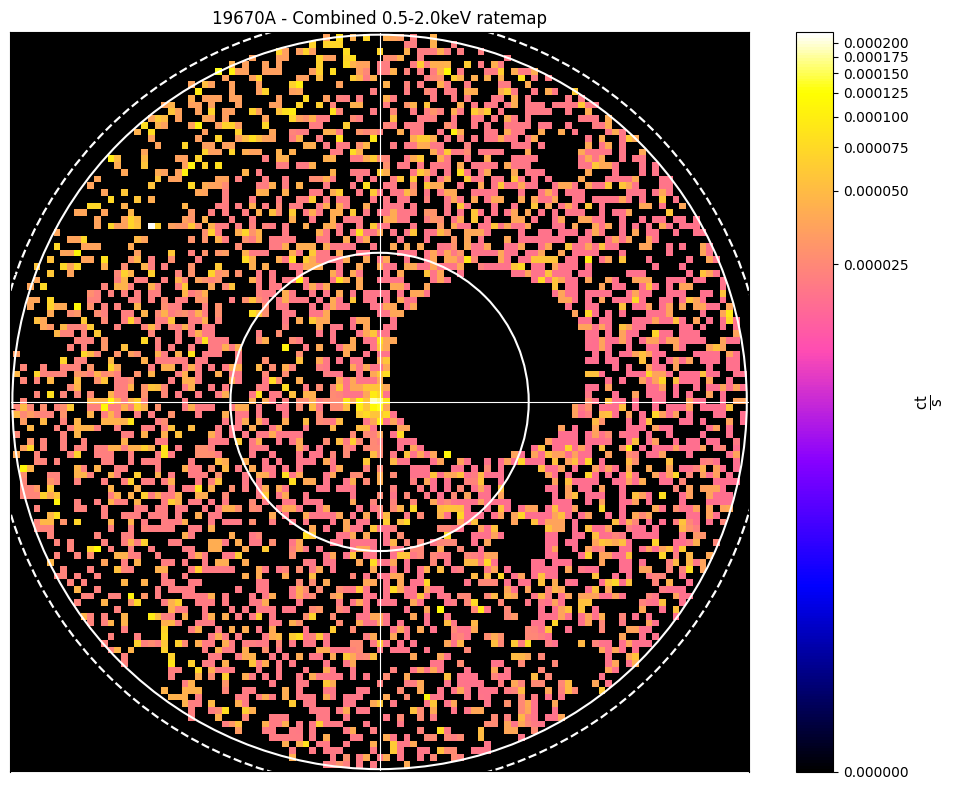

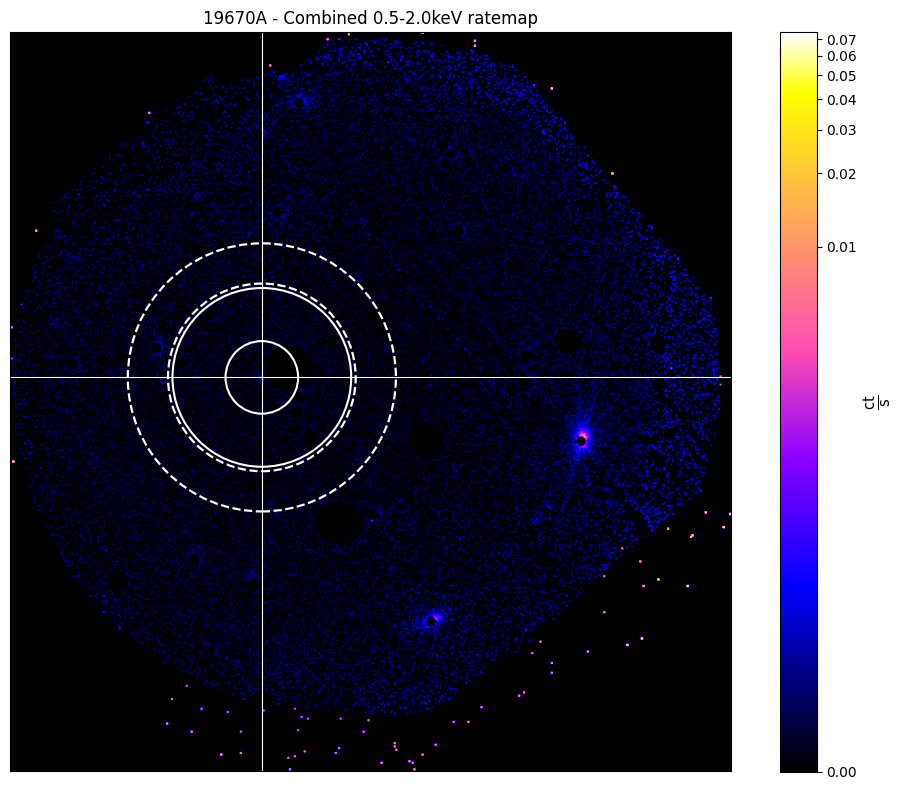

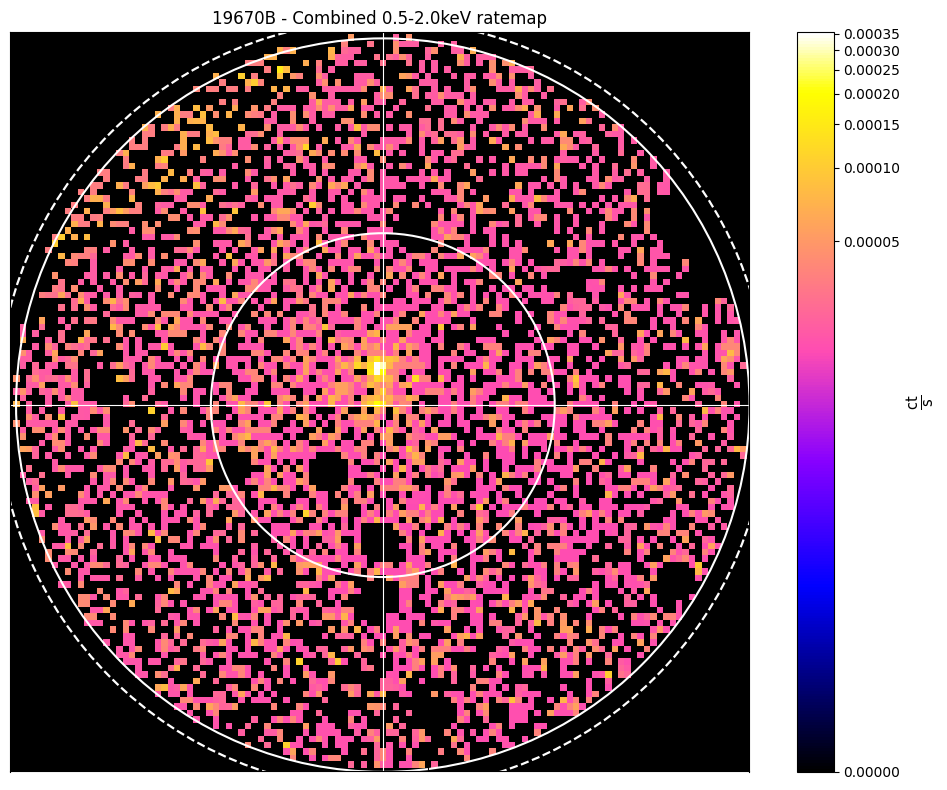

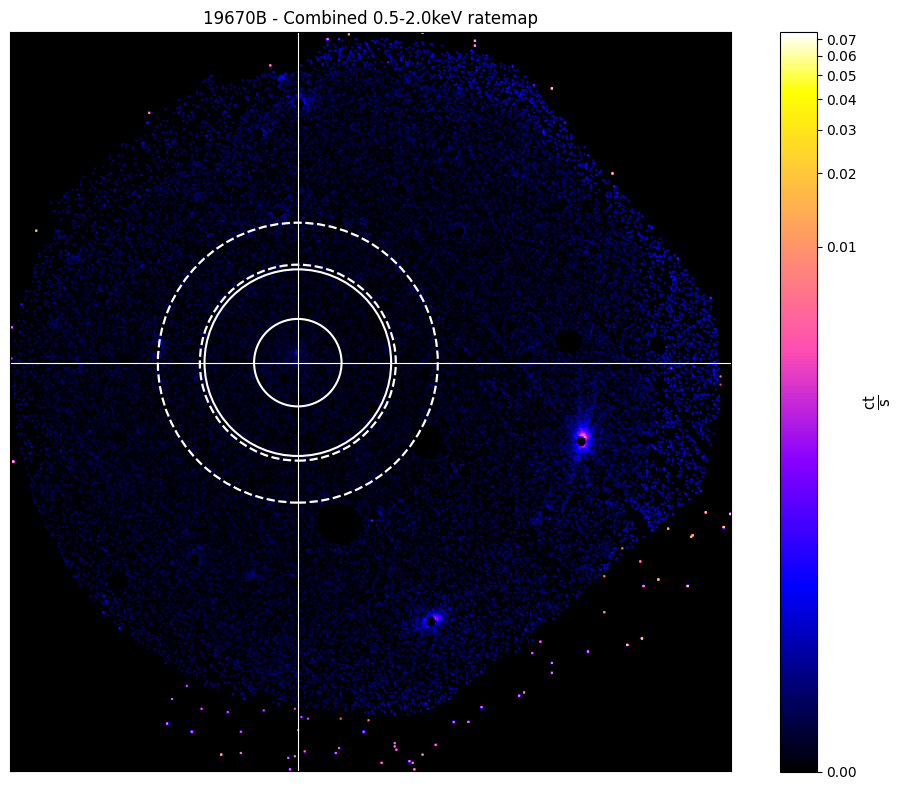

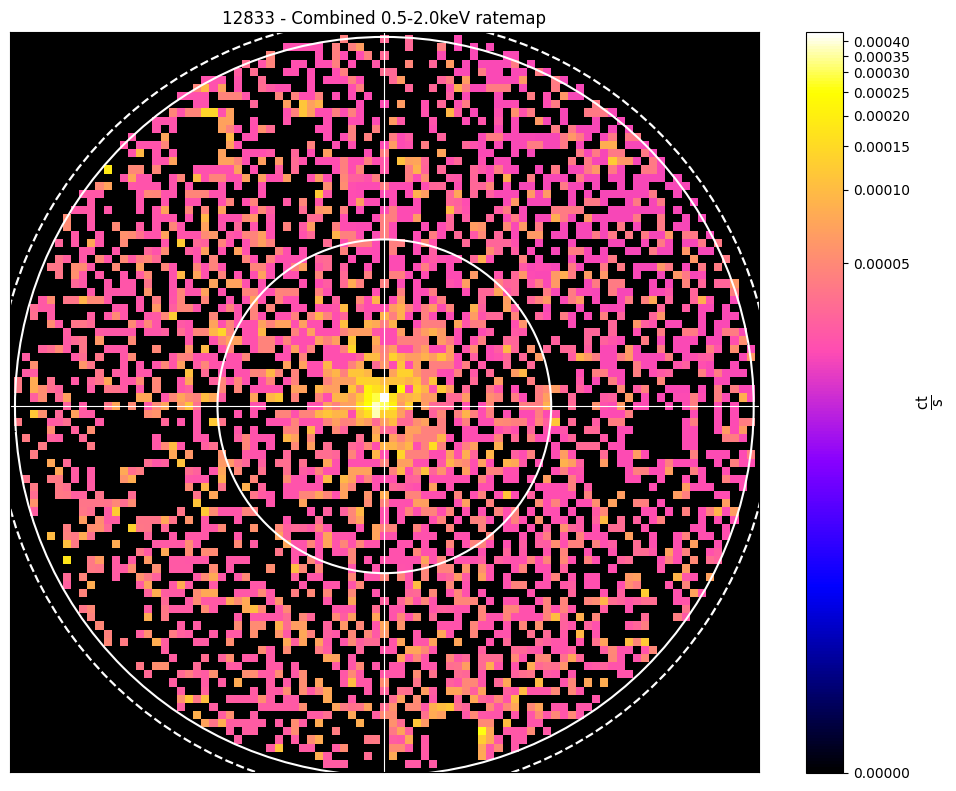

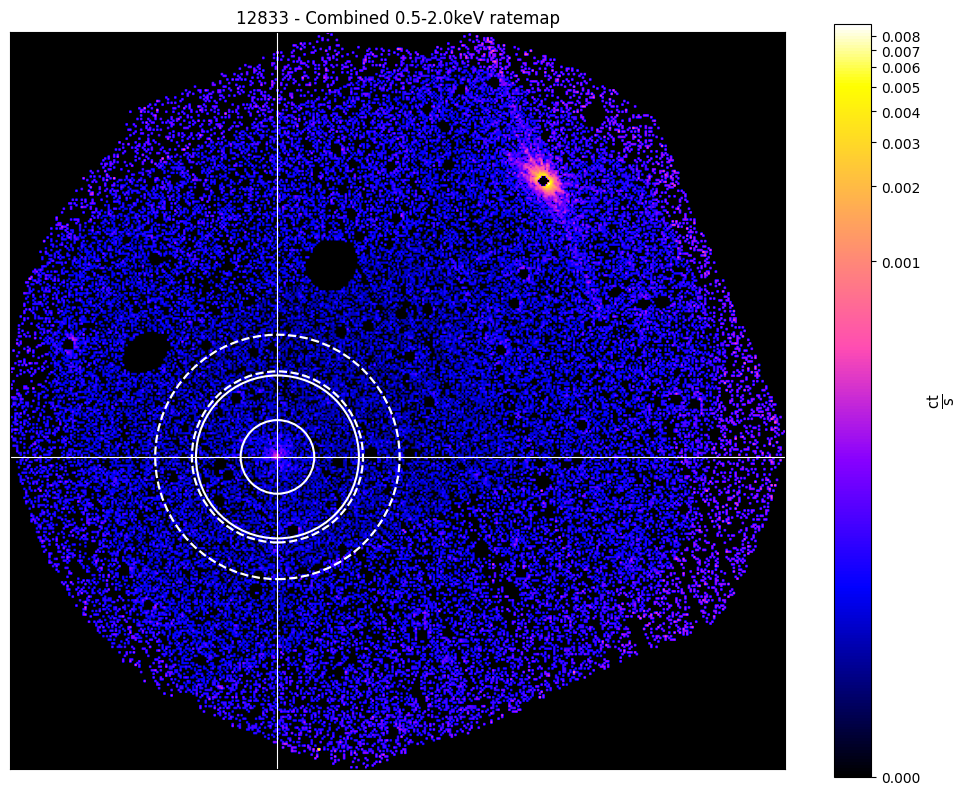

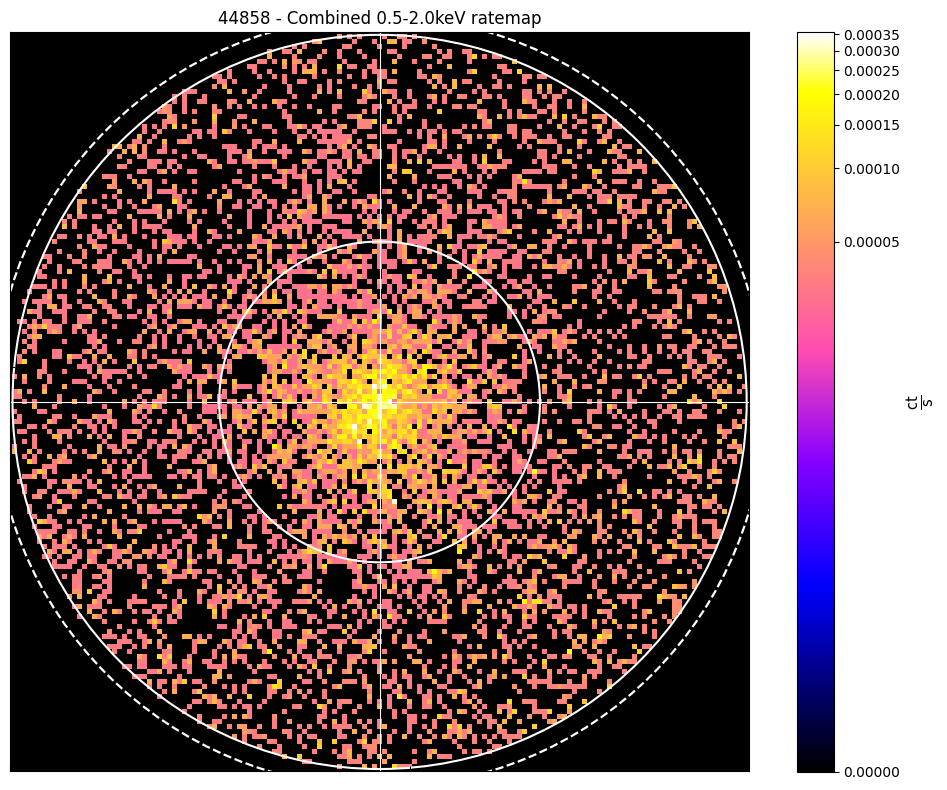

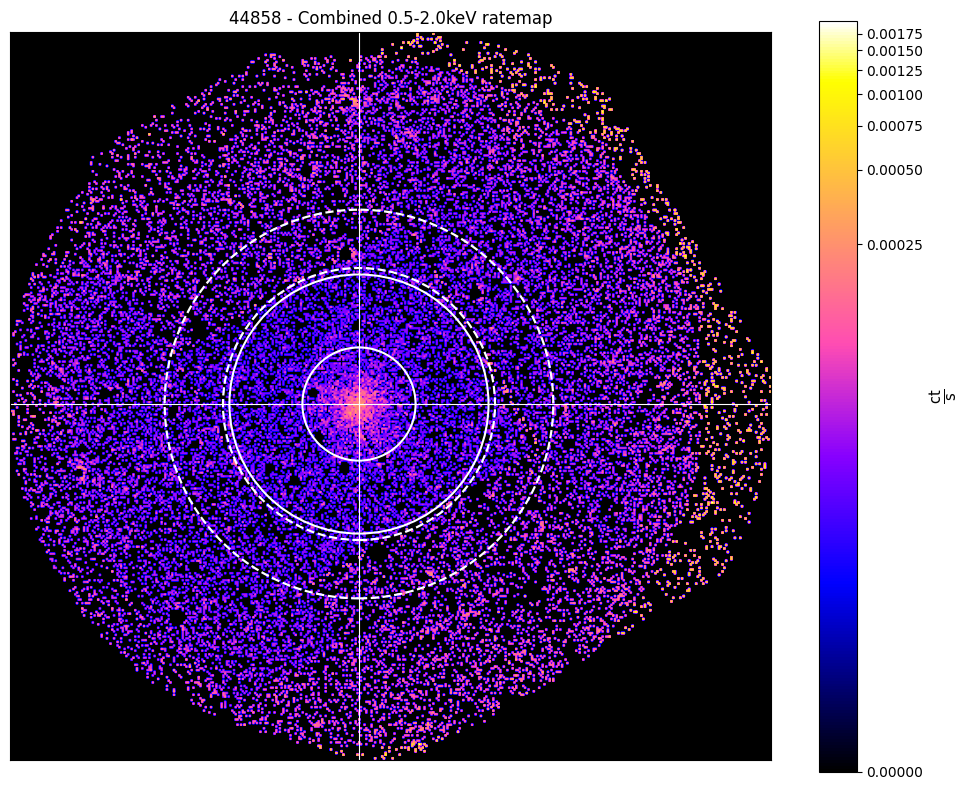

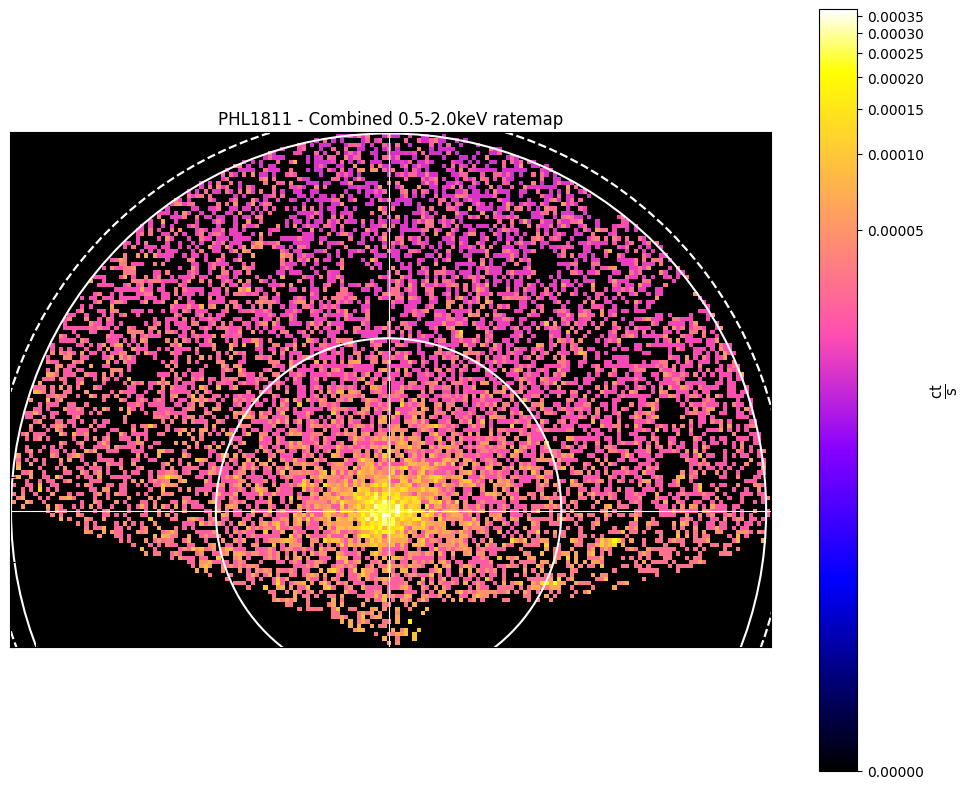

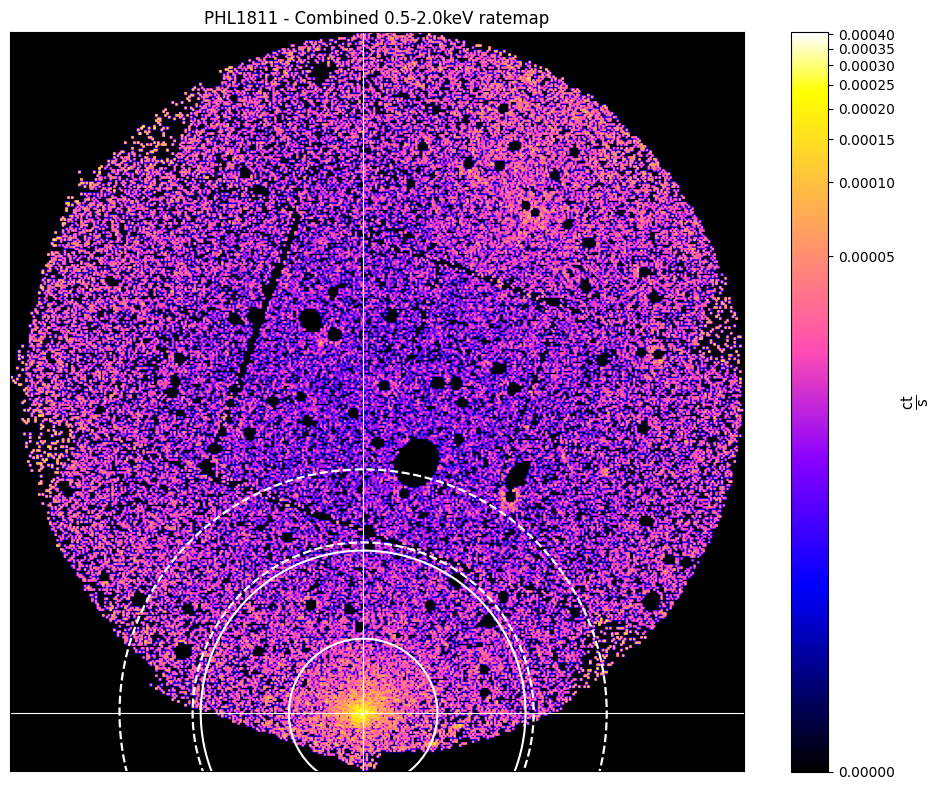

In [7]:
for src in srcs:
    rt = src.get_combined_ratemaps()
    
    # This uses an XGA convenience function which converts physical radii (such as your r500s) into pixels for a 
    #  particular photometric product (like an image or ratemap), so long as you can give it a redshift and cosmology
    src_ann = physical_rad_to_pix(rt, Quantity([src.r2500, src.r500]), src.ra_dec, src.redshift, src.cosmo)
    # This does the same thing as above but for the background radii, for which I multiply the current src's R500
    #  by the background radius factors (default is 1.05 and 1.5)
    bck_ann = physical_rad_to_pix(rt, Quantity(src.r500*src.background_radius_factors), src.ra_dec, 
                                  src.redshift, src.cosmo)
    # This makes the visualisation with the R500 mask (with contaminants masked as well), zoomed in on the region
    rt.view(src.ra_dec, src.get_mask('r500')[0], zoom_in=True, 
            radial_bins_pix=src_ann.value, back_bin_pix=bck_ann.value)    
    # This applied an mask only to remove contaminants, and so we can see the whole FoV
    rt.view(src.ra_dec, src.get_interloper_mask(), zoom_in=True,  
            radial_bins_pix=src_ann.value, back_bin_pix=bck_ann.value)


## Quick-look at $S_{\rm{B}}$ profiles

We can take a quick look at surface brightness profiles generated with default settings, to get an idea of what we're working with. They will be generated out to $R_{500}$, with the background taken from the [1.05-1.5]$R_{500}$ region:

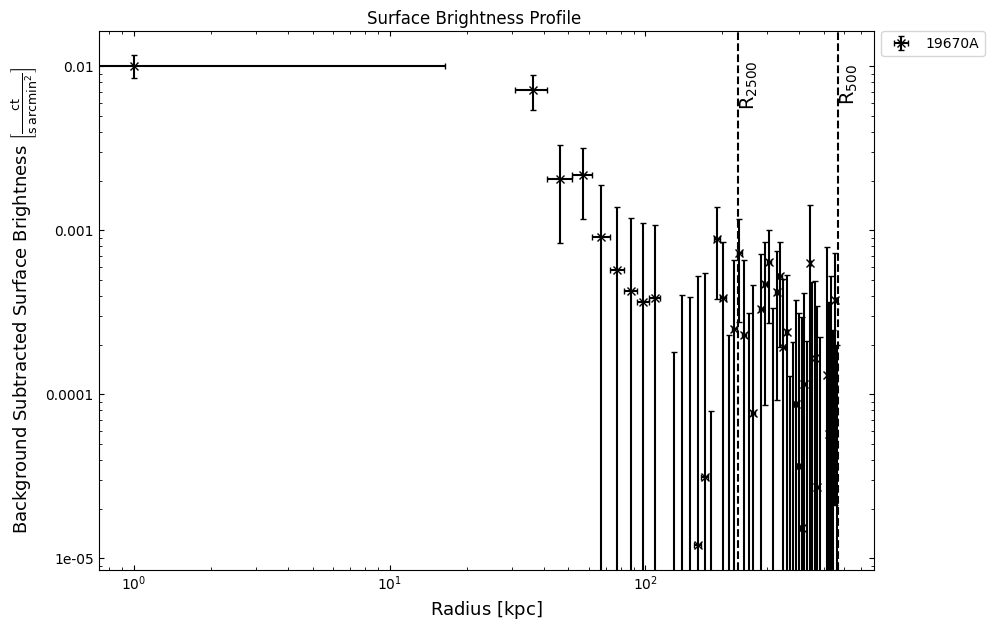

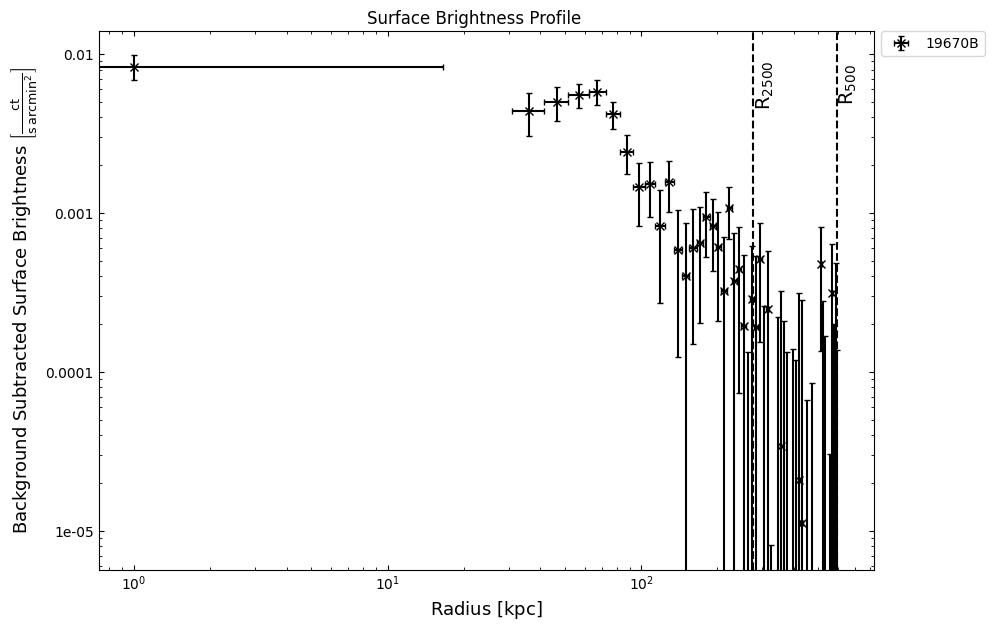

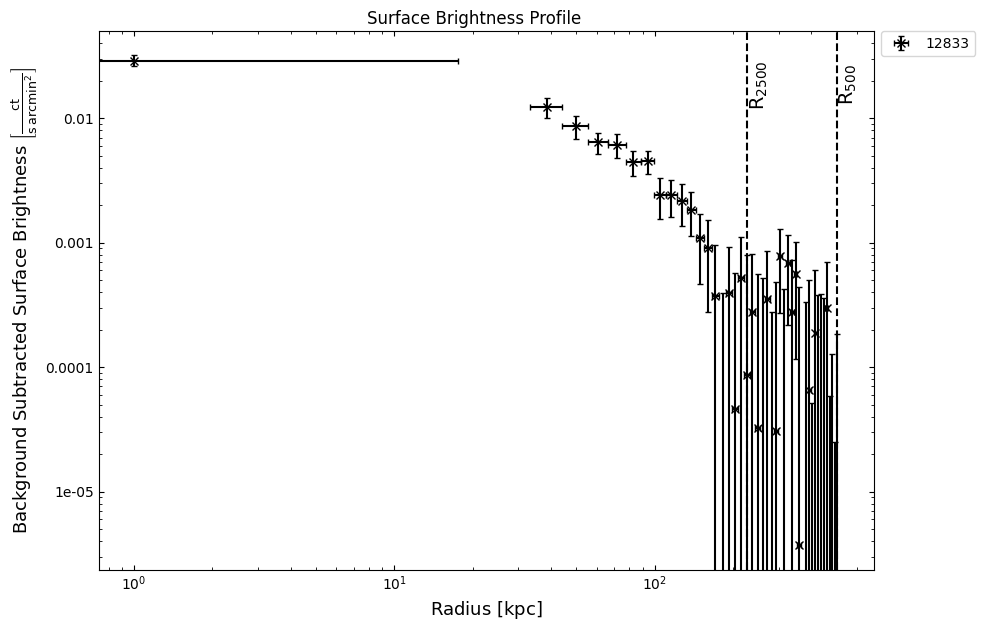

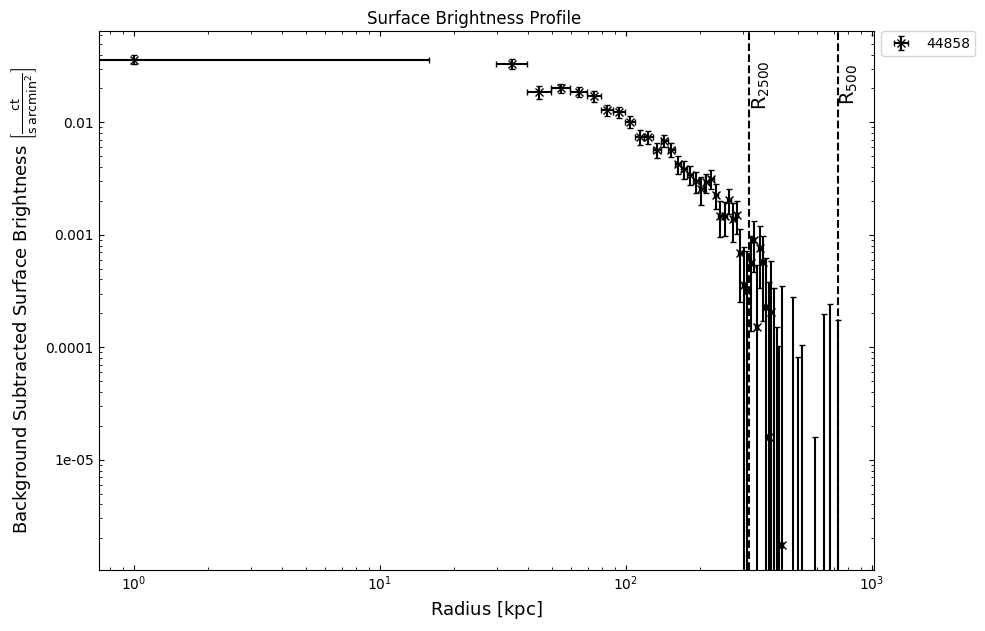

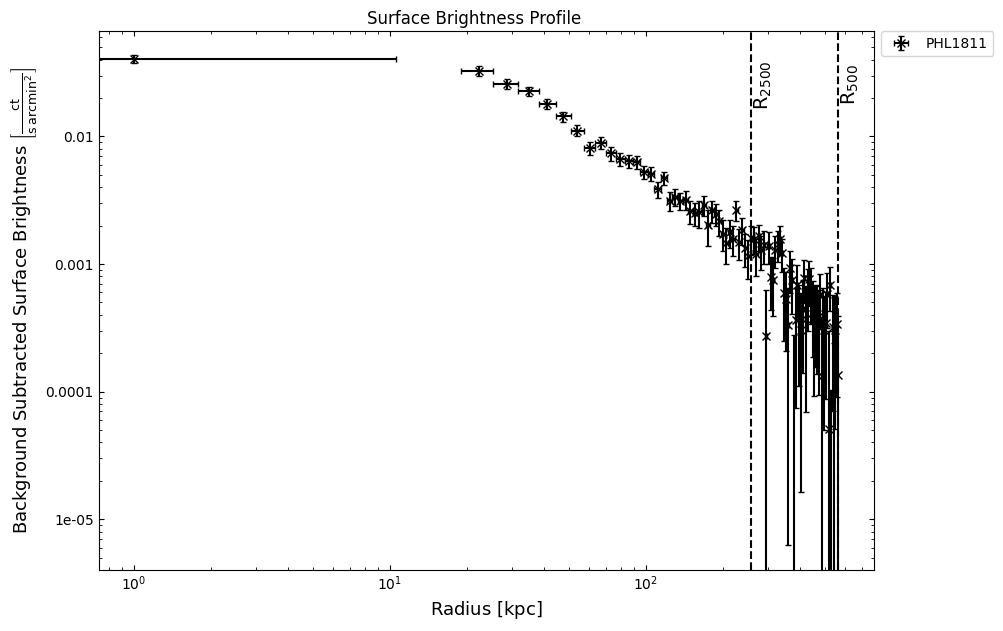

In [8]:
for src in srcs:
    src.view_brightness_profile('r500')

## Running density profile measurement

This parametric method for measuring the density does not necessarily reflect any small features in the radial profile (local peaks of emission, discontinuties, etc.) but it will do for now. A double-$\beta$ profile is fit to the PSF corrected surface brightness profiles (that process may struggle with some of these groups), which is then deprojected and converted to a density profile:

In [15]:
rl_psf(srcs, bins=10, num_cores=40)
dens_profs = inv_abel_fitted_model(srcs, 'double_beta', use_peak=False, num_cores=40, psf_bins=10)

/mnt/ufs18/home-218/turne540/code/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:   0%|          | 0/5 [00:00<?, ?it/s]/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy-5.2.1-py3.9-linux-x86_64.egg/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/ufs18/home-218/turne540/code/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of 19670A's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  20%|██        | 1/5 [00:16<01:05, 16.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [503.64196086 766.38151722 841.77933483 482.59710306 739.59444921
 850.32197429]


/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy-5.2.1-py3.9-linux-x86_64.egg/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/ufs18/home-218/turne540/code/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of 19670B's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  40%|████      | 2/5 [00:33<00:50, 16.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 315.57619908  700.93487063 1046.44628283  316.32863111  597.78854938
 1013.88004082]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 284.49954665 1108.55930487 1020.88321153  384.96042394 1050.56930834
 1048.59238096]


Fitting data, inverse Abel transforming, and measuring densities:  60%|██████    | 3/5 [00:51<00:34, 17.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [310.10678717 454.36445613 367.40040426 373.52916755 461.06354857
 455.42354535]


Fitting data, inverse Abel transforming, and measuring densities:  80%|████████  | 4/5 [01:08<00:17, 17.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 355.56704914  555.35727132 1608.54563901 1234.98271268 1382.17569445
  938.20801828]


Fitting data, inverse Abel transforming, and measuring densities: 100%|██████████| 5/5 [01:29<00:00, 17.89s/it]


## Looking at the $\rho_{\rm{g}}$ profiles

Just viewing the profiles we've measured, they aren't all great at the moment!

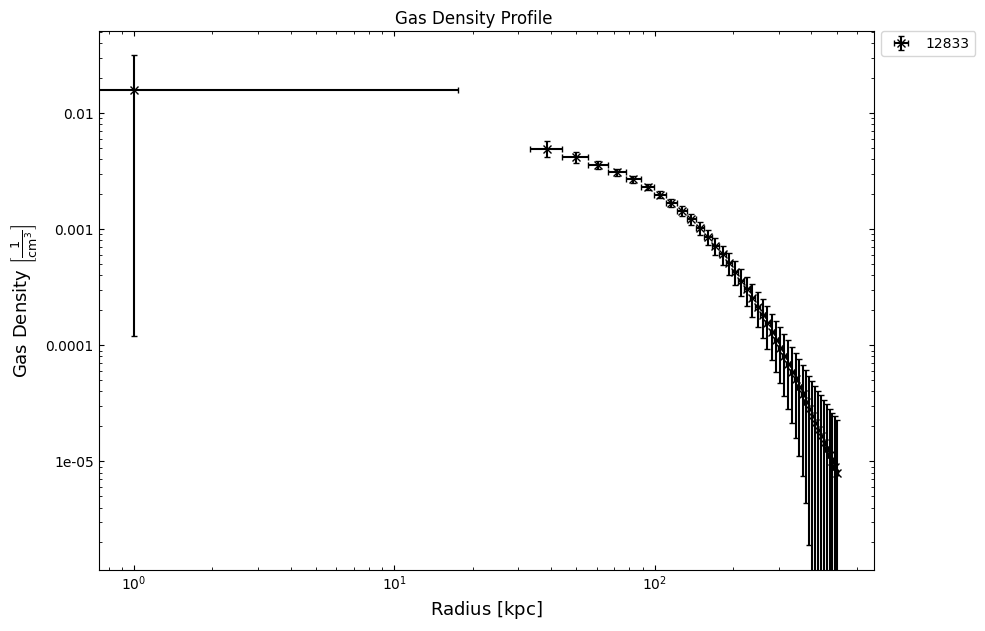

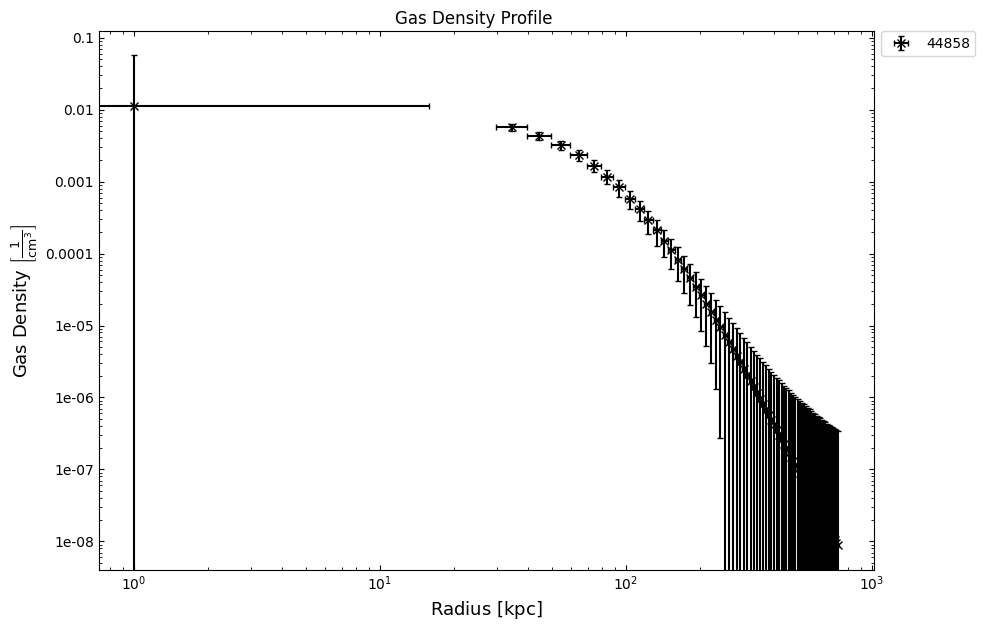

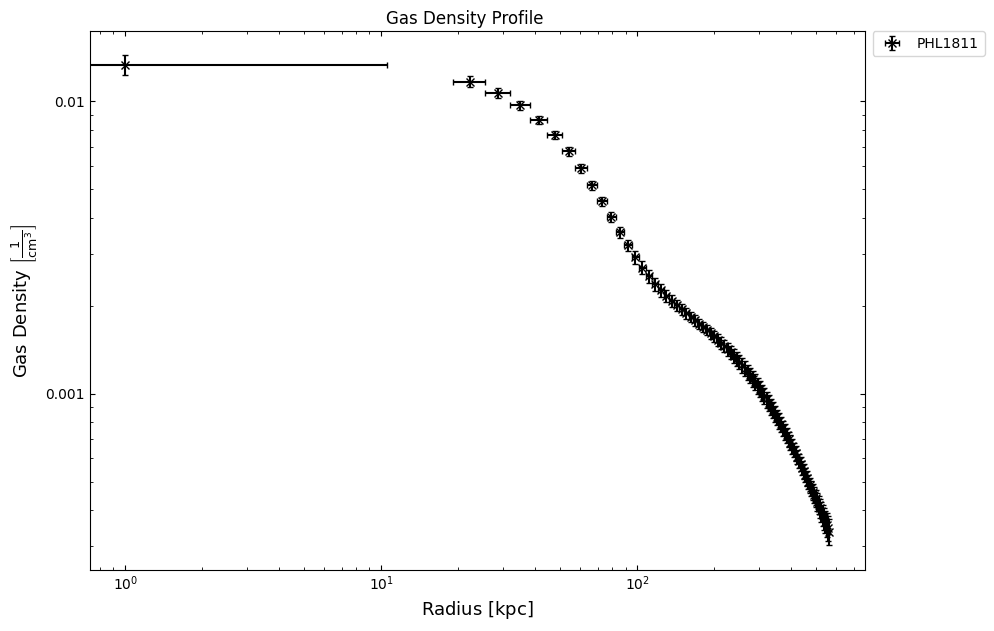

In [16]:
for dp in dens_profs:
    if dp is not None:
        dp.view()

## Calculating gas masses

Then we can do some quick gas mass calculations from those profiles, both within the $R_{2500}$ and $R_{500}$ radii:

100%|██████████| 30000/30000 [00:29<00:00, 1022.13it/s]


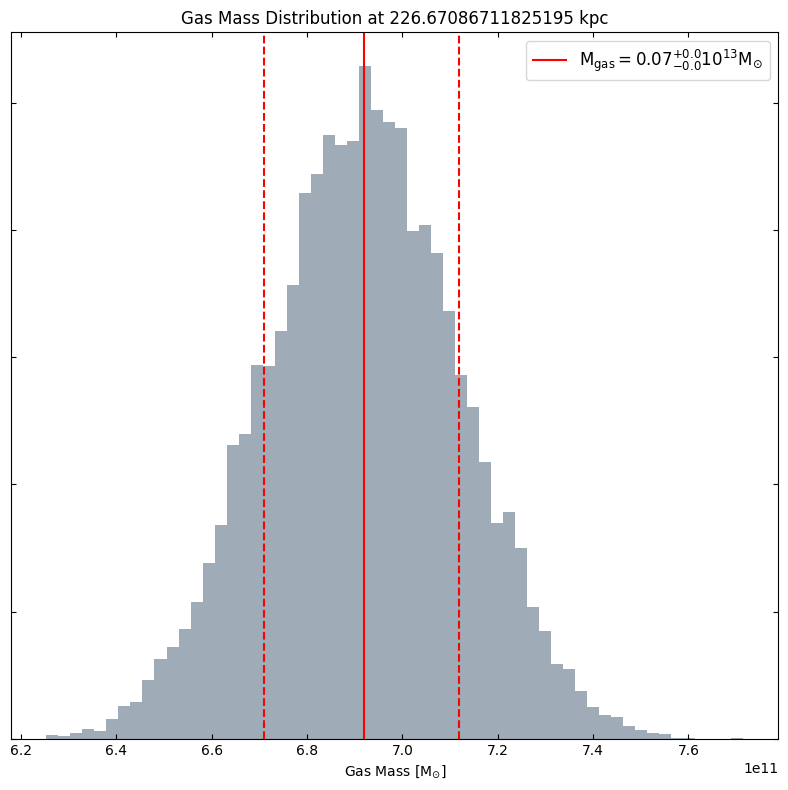

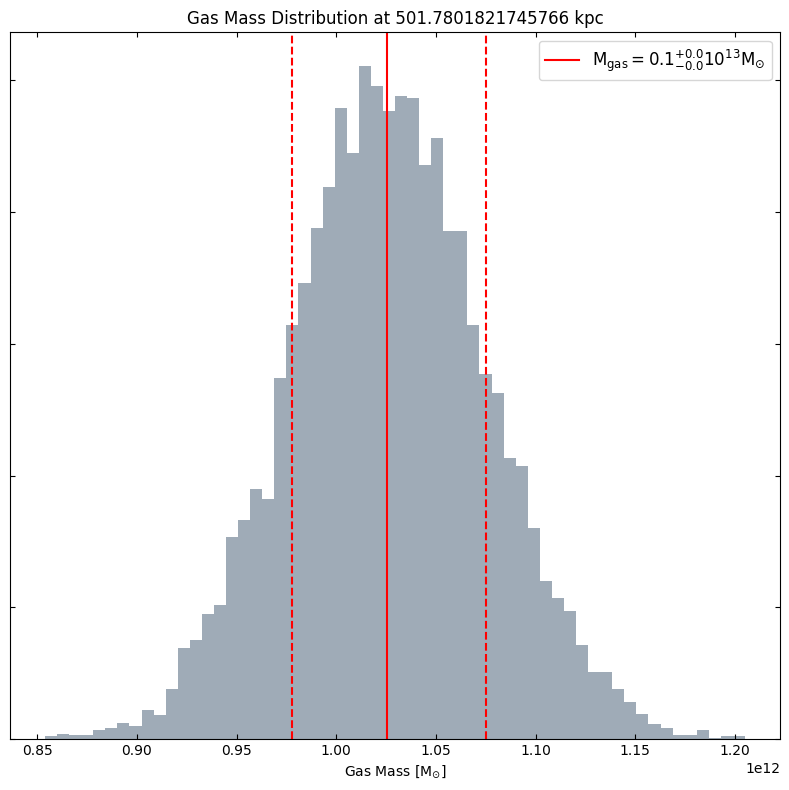

100%|██████████| 30000/30000 [00:30<00:00, 976.38it/s] 


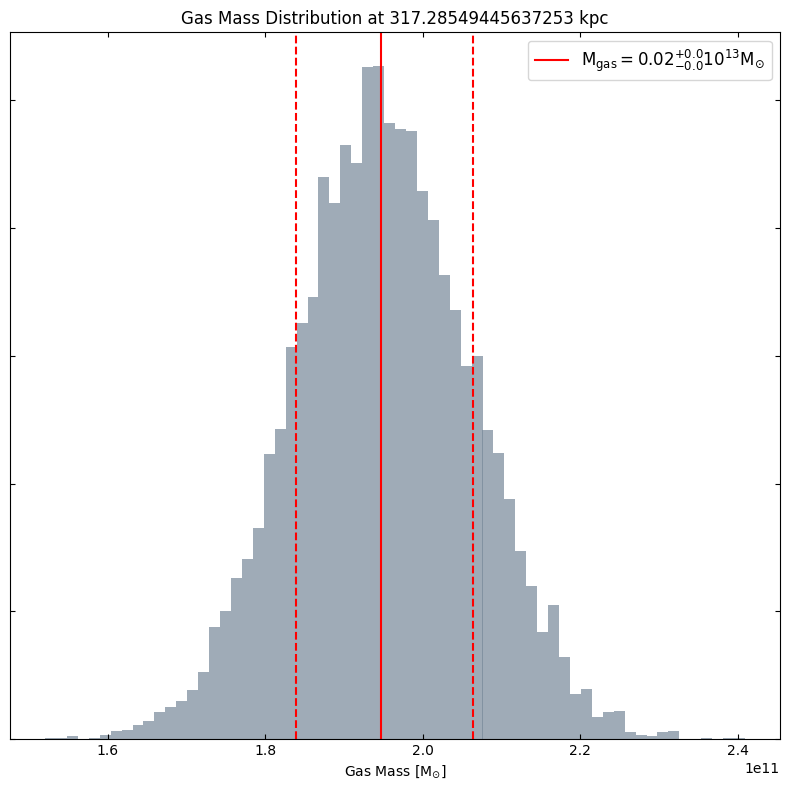

/mnt/ufs18/home-218/turne540/code/XGA/xga/products/profile.py:650: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gas_mass, gas_mass_dist = self.gas_mass(model, outer_rad, conf_level=conf_level, fit_method=fit_method)


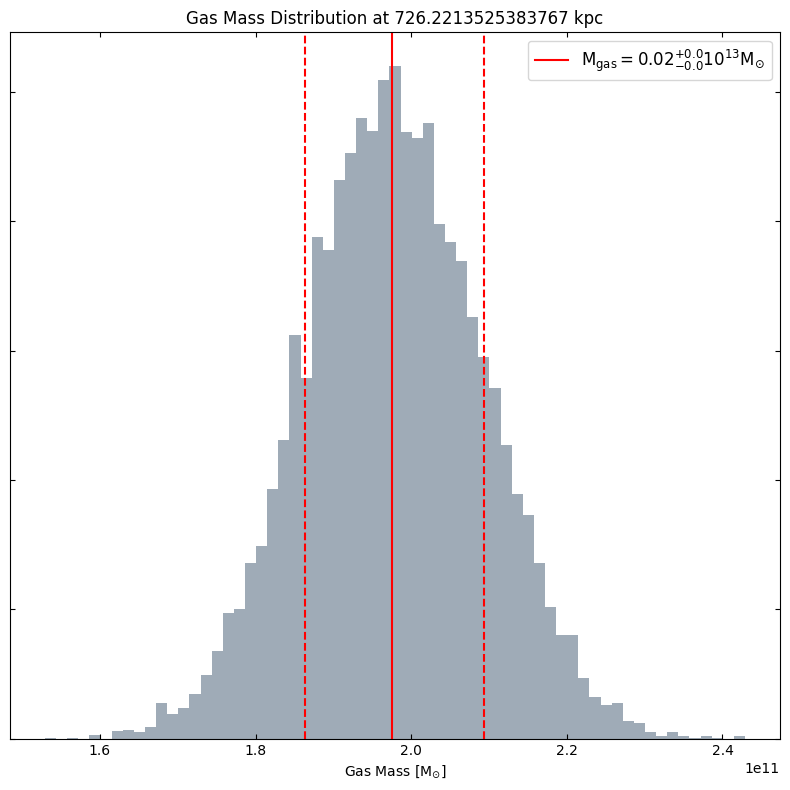

100%|██████████| 30000/30000 [00:36<00:00, 830.98it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [112.36644928 116.31238025 804.72579969 104.43318747 117.94626194
 124.14213867]


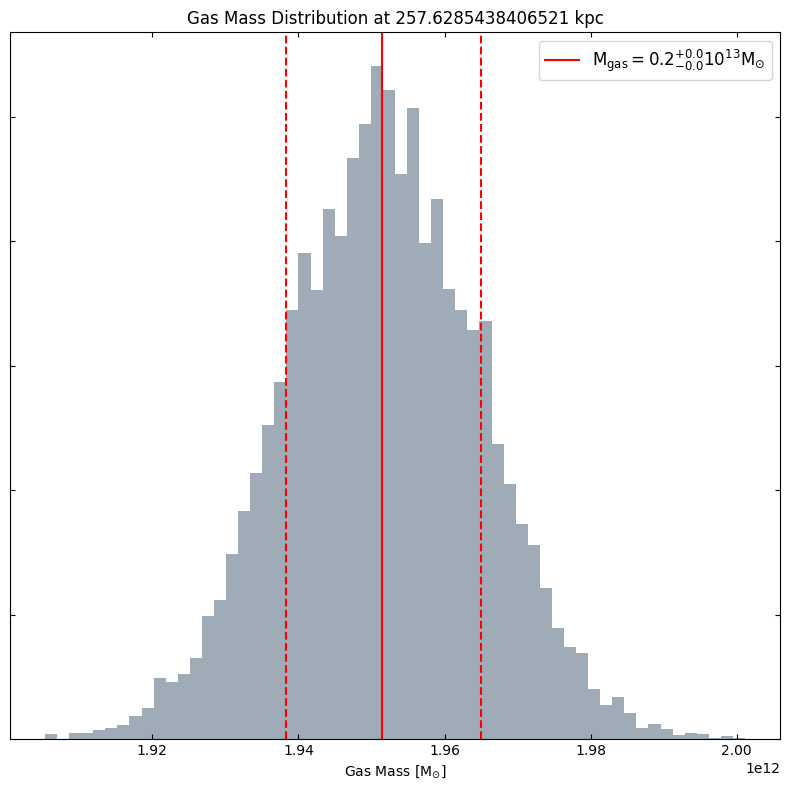

/mnt/ufs18/home-218/turne540/code/XGA/xga/products/profile.py:650: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gas_mass, gas_mass_dist = self.gas_mass(model, outer_rad, conf_level=conf_level, fit_method=fit_method)


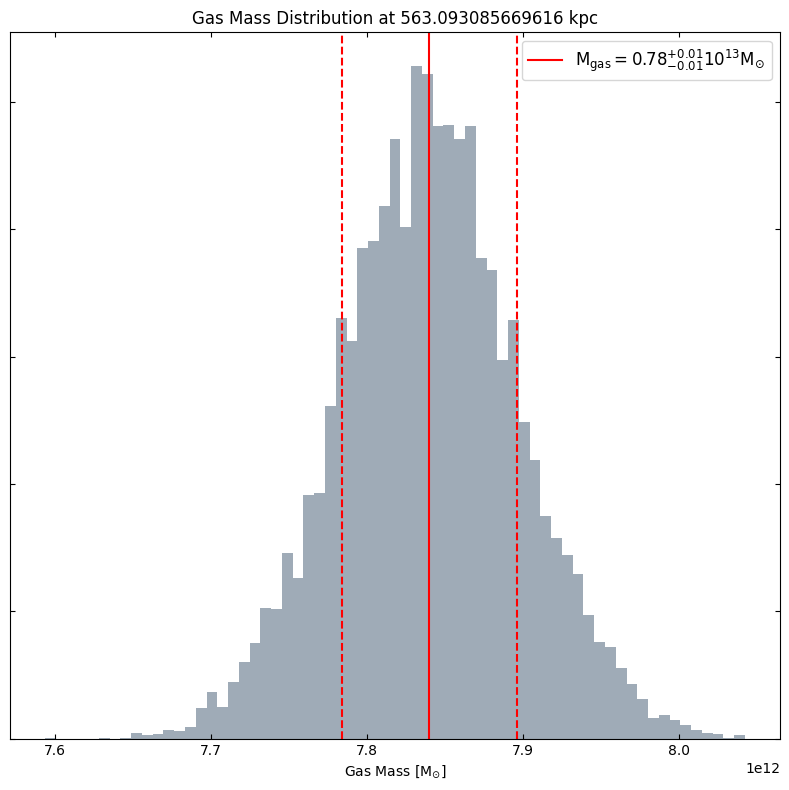

In [17]:
for dp in dens_profs:
    if dp is not None:
        dp.fit('simple_vikhlinin_dens')
        rel_src = srcs[dp.src_name]
        dp.view_gas_mass_dist('simple_vikhlinin_dens', rel_src.r2500)
        dp.view_gas_mass_dist('simple_vikhlinin_dens', rel_src.r500) 
        print('\n\n\n')